# Struttura dei test

In questo notebook si vuole svolgere un'analisi sulle performance del modulo
implementato (PPGA). Andremo quindi a confrontare:

- Versione sequenziale e versione parallela di PPGA.
- Confronto tra PPGA e DEAP (sequenziale e parallelo).
- Considerazioni finali sul problema specifico del paper per un corretto
  utilizzo della versione parallela ed evitare errori.

I benchmark sono stati effettuati su una macchina con doppio processore AMD
EPYC 7313, ciascuno dei quali a 16 core con frequenza di clock massima a 3.7
GHz. Il problema di riferimento è quello di explainability in cui è stato
eseguito l'algoritmo genetico su un solo punto del dataset (32 features) e su
una sola classe target. I parametri presi in considerazione sono:

- **Modello**: RandomForestClassifier, SVC e MLPClassifier
- **Numero di individui sintetici**: 1000, 2000, 4000, 8000, 16000
- **Numero di worker**: 1, 2, 4, 8, 16, 32. Le esecuzioni con 1 worker
  corrispondono in realtà alla versione sequenziale dell'algoritmo.

Sono state esplorate tutte le possibili combinazioni di tali parametri e, per
ciascuna di esse sono stati eseguiti 10 test. I risultati di tali test sono
stati poi aggregati prendendo media e deviazione standard dei tempi registrati.

In tutti i test sono stati registrati sia il tempo d'esecuzione totale
dell'algoritmo genetico, sia il tempo d'esecuzione specifico della parte
parallelizzata, sincronizzazione compresa, nel caso dei DEAP la sola
valutazione, nel caso di `ppga` le fasi di crossover, mutazione e valutazione.

# Analisi PPGA

Per prima cosa si vogliono paragonare le prestazioni offerte dalla versione
parallela dell'algoritmo rispetto a alla sua versione sequenziale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ppga_df = pd.read_csv("../datasets/ppga_benchmark_16.csv")
ppga_df

,classifier,population_size,workers,time,time_std
0,RandomForestClassifier,1000,1,16.235809,0.139895
1,RandomForestClassifier,1000,2,8.446167,0.053781
2,RandomForestClassifier,1000,4,4.404420,0.044924
3,RandomForestClassifier,1000,8,2.536529,0.074973
4,RandomForestClassifier,1000,16,1.869966,0.098601
...,...,...,...,...,...
85,MLPClassifier,16000,2,5.873115,0.069080
86,MLPClassifier,16000,4,3.631834,0.027850
87,MLPClassifier,16000,8,2.844125,0.207561
88,MLPClassifier,16000,16,2.562643,0.116255


## Tempo d'esecuzione

Iniziamo con un semplice grafico che riporta l'andamento del tempo d'esecuzione
in funzione del diverso numero di worker e su diverse dimensioni dell'input.


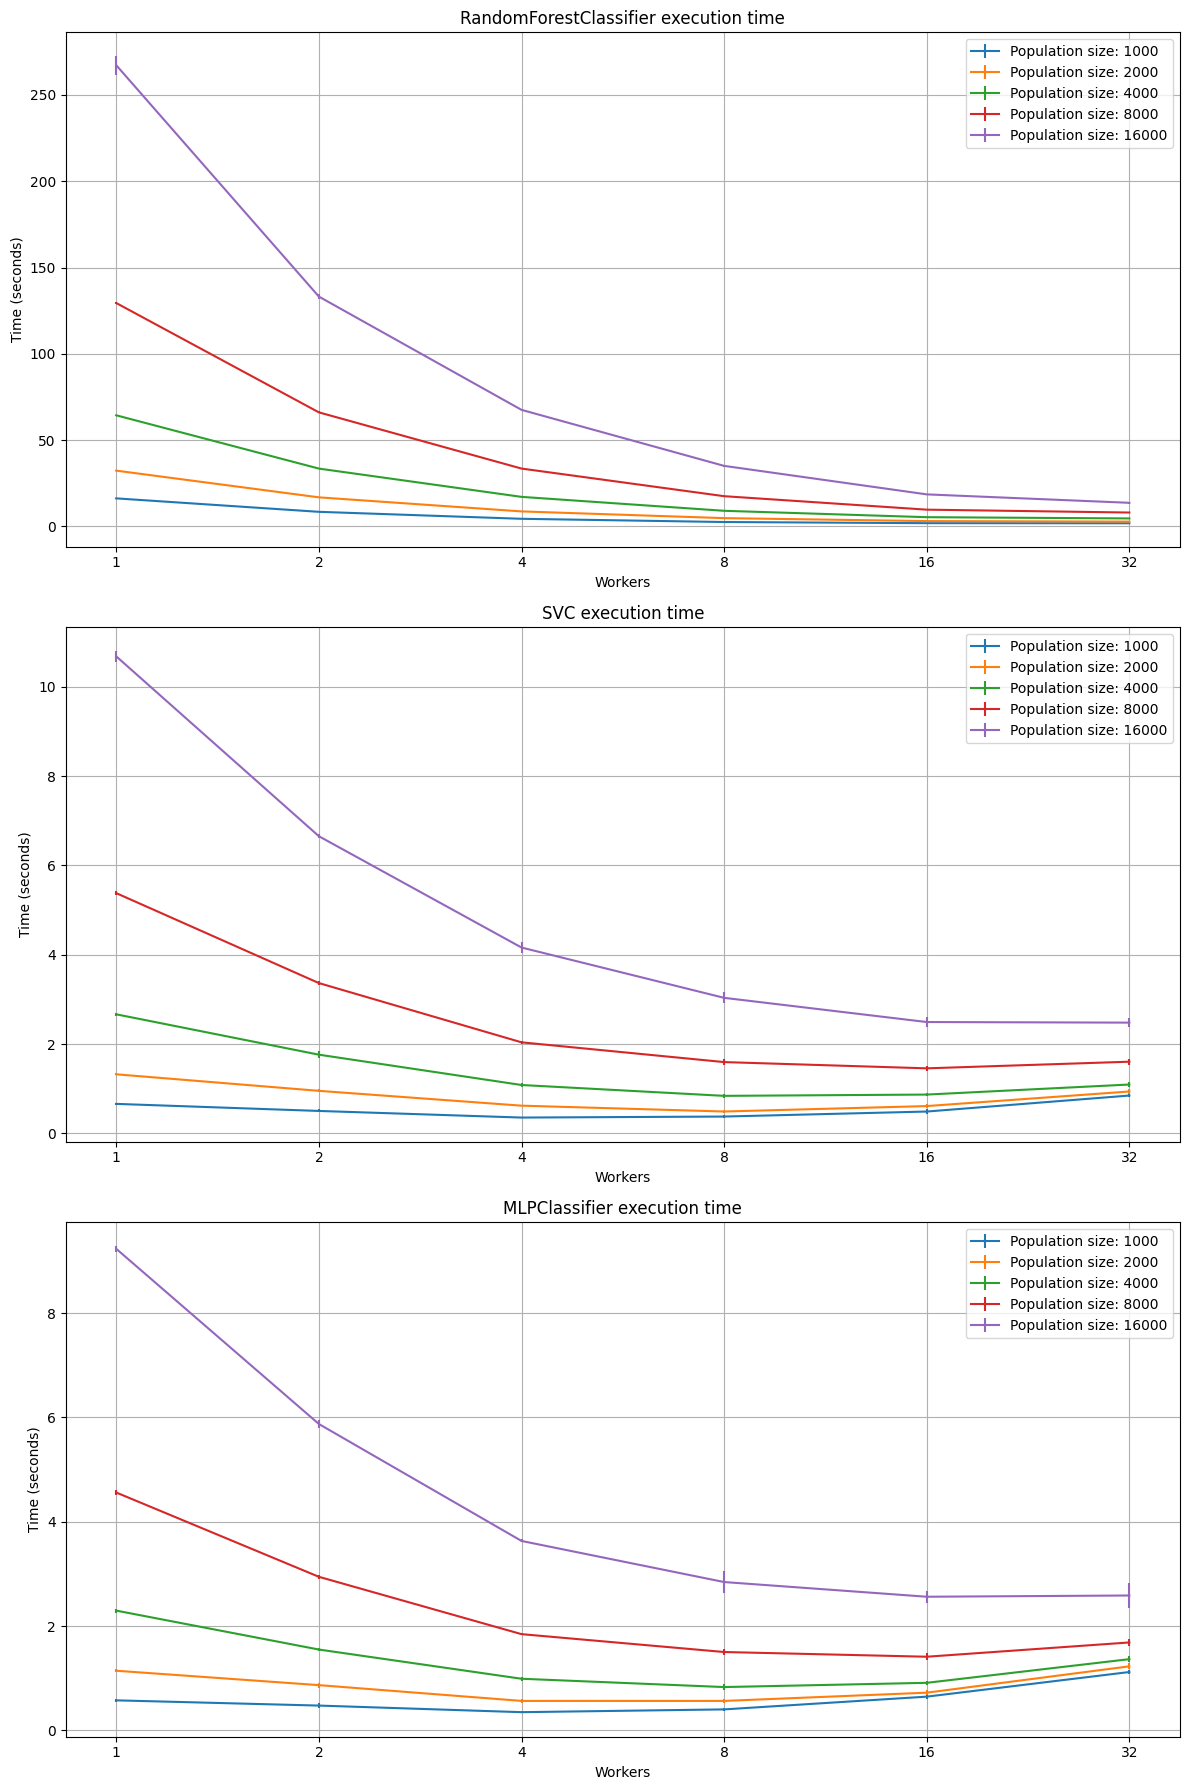

In [2]:
def plot_time(df: pd.DataFrame):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))
    
    for model, ax in zip(models, axes):
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            ax.set_title(f"{model} execution time")
            ax.set_xlabel("Workers")
            ax.set_ylabel("Time (seconds)")
            ax.errorbar(workers, df[mask]["time"].values, df[mask]["time_std"], label=f"Population size: {ps}")
    
            ax.set_xscale("log", base=2)
            ax.set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            ax.grid()
            ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_time(ppga_df)

## Speed up

Procediamo con il calcolare lo _speed up_ ottenuto per ogni modello e per ogni
numero di individui sintetici.

In [3]:
reference_times = ppga_df[ppga_df['workers'] == 1].set_index(['classifier', 'population_size'])['time']

ppga_df['speed_up'] = ppga_df.apply(lambda row: reference_times.loc[(row['classifier'], row['population_size'])] / row['time'], axis=1)
ppga_df

,classifier,population_size,workers,time,time_std,speed_up
0,RandomForestClassifier,1000,1,16.235809,0.139895,1.000000
1,RandomForestClassifier,1000,2,8.446167,0.053781,1.922270
2,RandomForestClassifier,1000,4,4.404420,0.044924,3.686253
3,RandomForestClassifier,1000,8,2.536529,0.074973,6.400798
4,RandomForestClassifier,1000,16,1.869966,0.098601,8.682410
...,...,...,...,...,...,...
85,MLPClassifier,16000,2,5.873115,0.069080,1.571575
86,MLPClassifier,16000,4,3.631834,0.027850,2.541427
87,MLPClassifier,16000,8,2.844125,0.207561,3.245302
88,MLPClassifier,16000,16,2.562643,0.116255,3.601767


Di seguito vari grafici per vedere l'andamento dello speed up in relazione
al numero di individui sintetici generati.

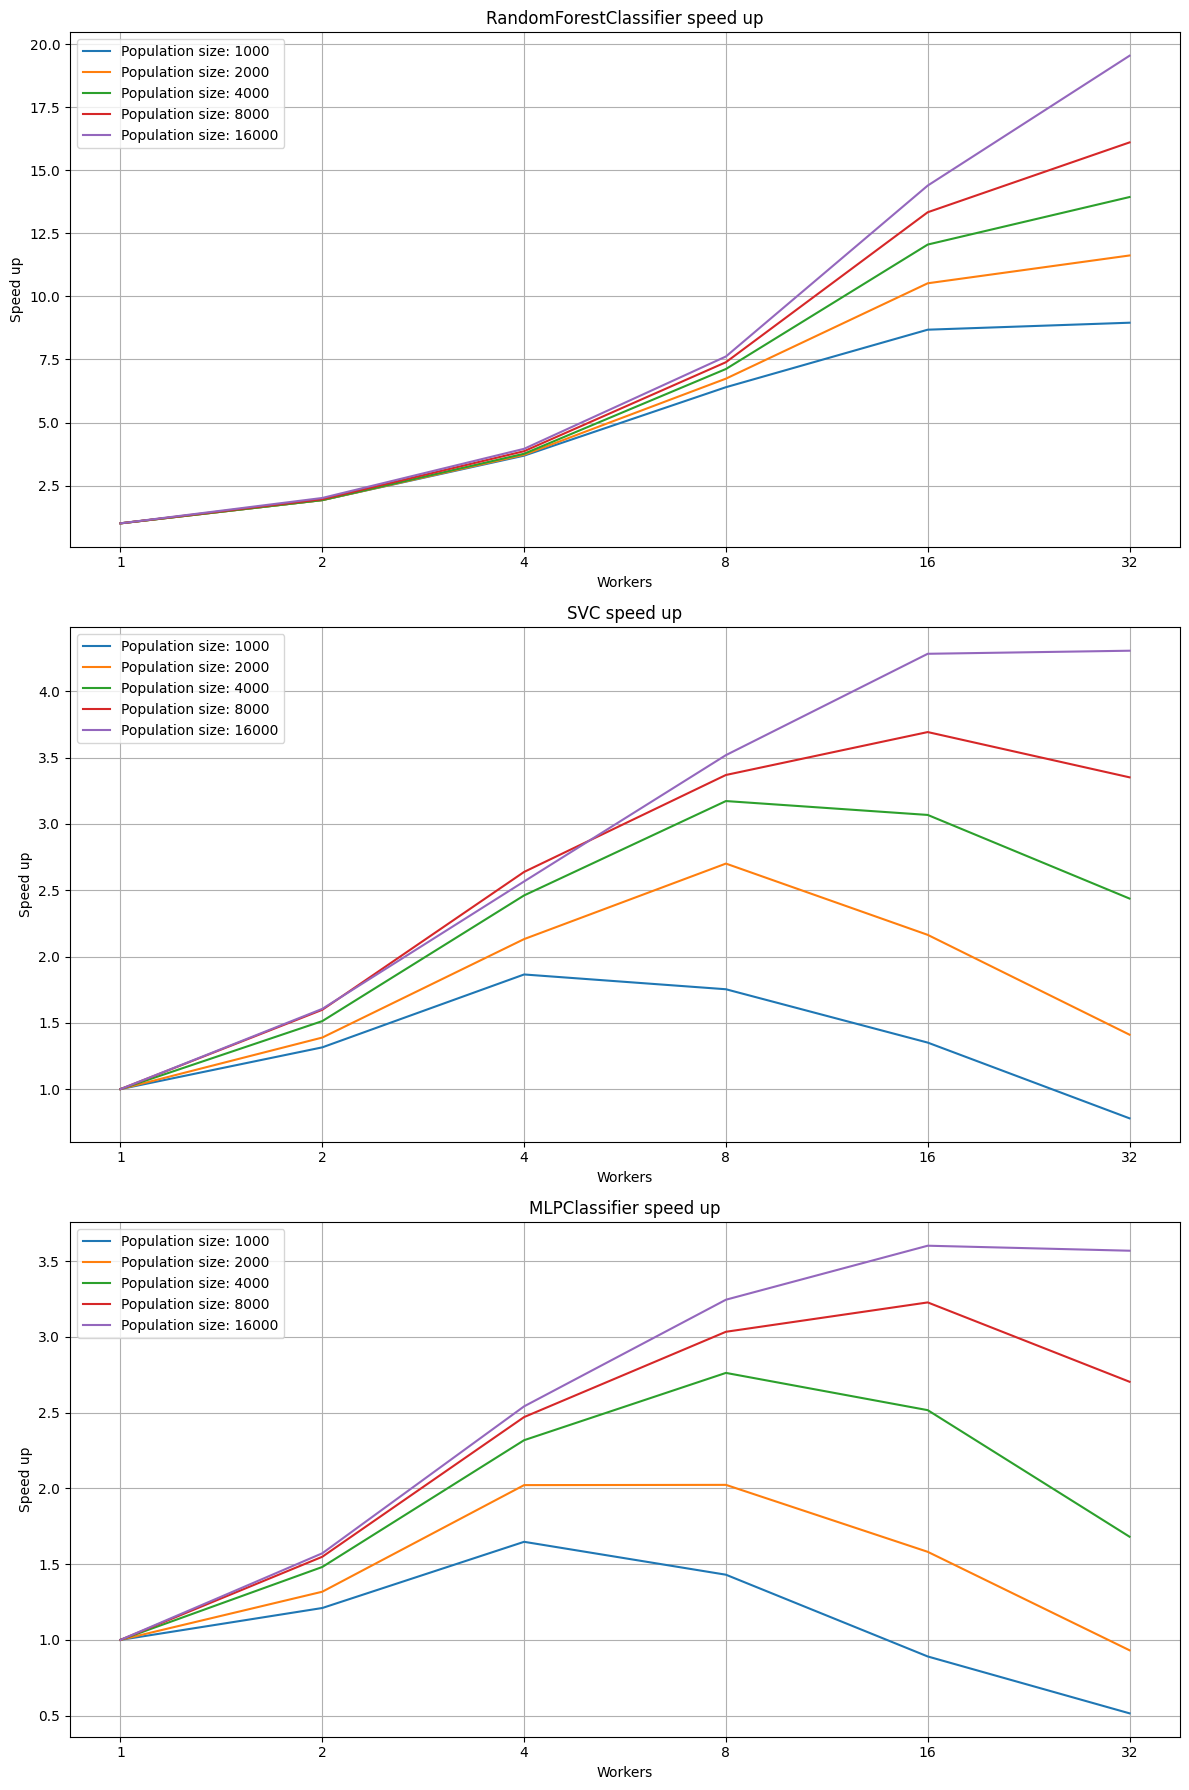

In [4]:
def plot_speed_up(df: pd.DataFrame):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))
    
    for model, ax in zip(models, axes):
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            ax.set_title(f"{model} speed up")
            ax.set_xlabel("Workers")
            ax.set_ylabel("Speed up")
            ax.plot(workers, df[mask]["speed_up"].values, label=f"Population size: {ps}")
    
            ax.set_xscale("log", base=2)
            ax.set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            ax.grid()
            ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_speed_up(ppga_df)

Come è facile notare, il Random Forest, che è anche il più lento, è quello che
trae più beneficio da una parallelizzazione più pesante. Gli altri modelli
sono molto più performanti in fase di predizione ed è quindi più difficile
ottenere un valore di speed up vicino al numero di worker utilizzati.

Nel problema di explainability in cui si richiedono numerose esecuzioni
dell'algoritmo genetico, si potrebbe pensare di partizionare il dataset in $m$
parti e adibire $n$ core a ciascuna partizione di modo da eseguire l'algoritmo
genetico parallelo su $n$ core e su $m$ punti contemporaneamente. Ovviamente
è necessaria un'analisi preliminare in cui si cerca di approssimare il numero 
di worker più adatto ad una singola esecuzione dell'algoritmo genetico. Il
numero di partizioni del dataset sarà semplicemente calcolato come:

$$\frac{ct}{w}$$

dove $ct$ è il numero di core totali presenti sulla macchina o che si intende
utilizzare e $w$ è il numero di worker stimato al passo precedente.

## Stabilità

Come ultima analisi vorrei valutare la stabilità delle performance
dell'algoritmo stesso andando a calcolare il coefficiente di variazione
del tempo impiegato. Andiamo quindi a calcolare

$$\frac{\sigma}{\mu}$$

dove $\mu$ e $\sigma$ sono media e deviazione standard dei tempi d'esecuzione
ottenuti da 10 prove ripetute dello stesso test.

In [5]:
ppga_df["var_coeff"] = ppga_df["time_std"] / ppga_df["time"]
ppga_df

,classifier,population_size,workers,time,time_std,speed_up,var_coeff
0,RandomForestClassifier,1000,1,16.235809,0.139895,1.000000,0.008616
1,RandomForestClassifier,1000,2,8.446167,0.053781,1.922270,0.006367
2,RandomForestClassifier,1000,4,4.404420,0.044924,3.686253,0.010200
3,RandomForestClassifier,1000,8,2.536529,0.074973,6.400798,0.029557
4,RandomForestClassifier,1000,16,1.869966,0.098601,8.682410,0.052729
...,...,...,...,...,...,...,...
85,MLPClassifier,16000,2,5.873115,0.069080,1.571575,0.011762
86,MLPClassifier,16000,4,3.631834,0.027850,2.541427,0.007668
87,MLPClassifier,16000,8,2.844125,0.207561,3.245302,0.072979
88,MLPClassifier,16000,16,2.562643,0.116255,3.601767,0.045365


In questo modo è possibile vedere la stabilità dell'algoritmo al variare di
parametri come numero di worker e dimensioni della popolazione. Come soglia
per separare i test più stabili dagli altri ho scelto un valore del 10% per
il coefficiente di variabilità.

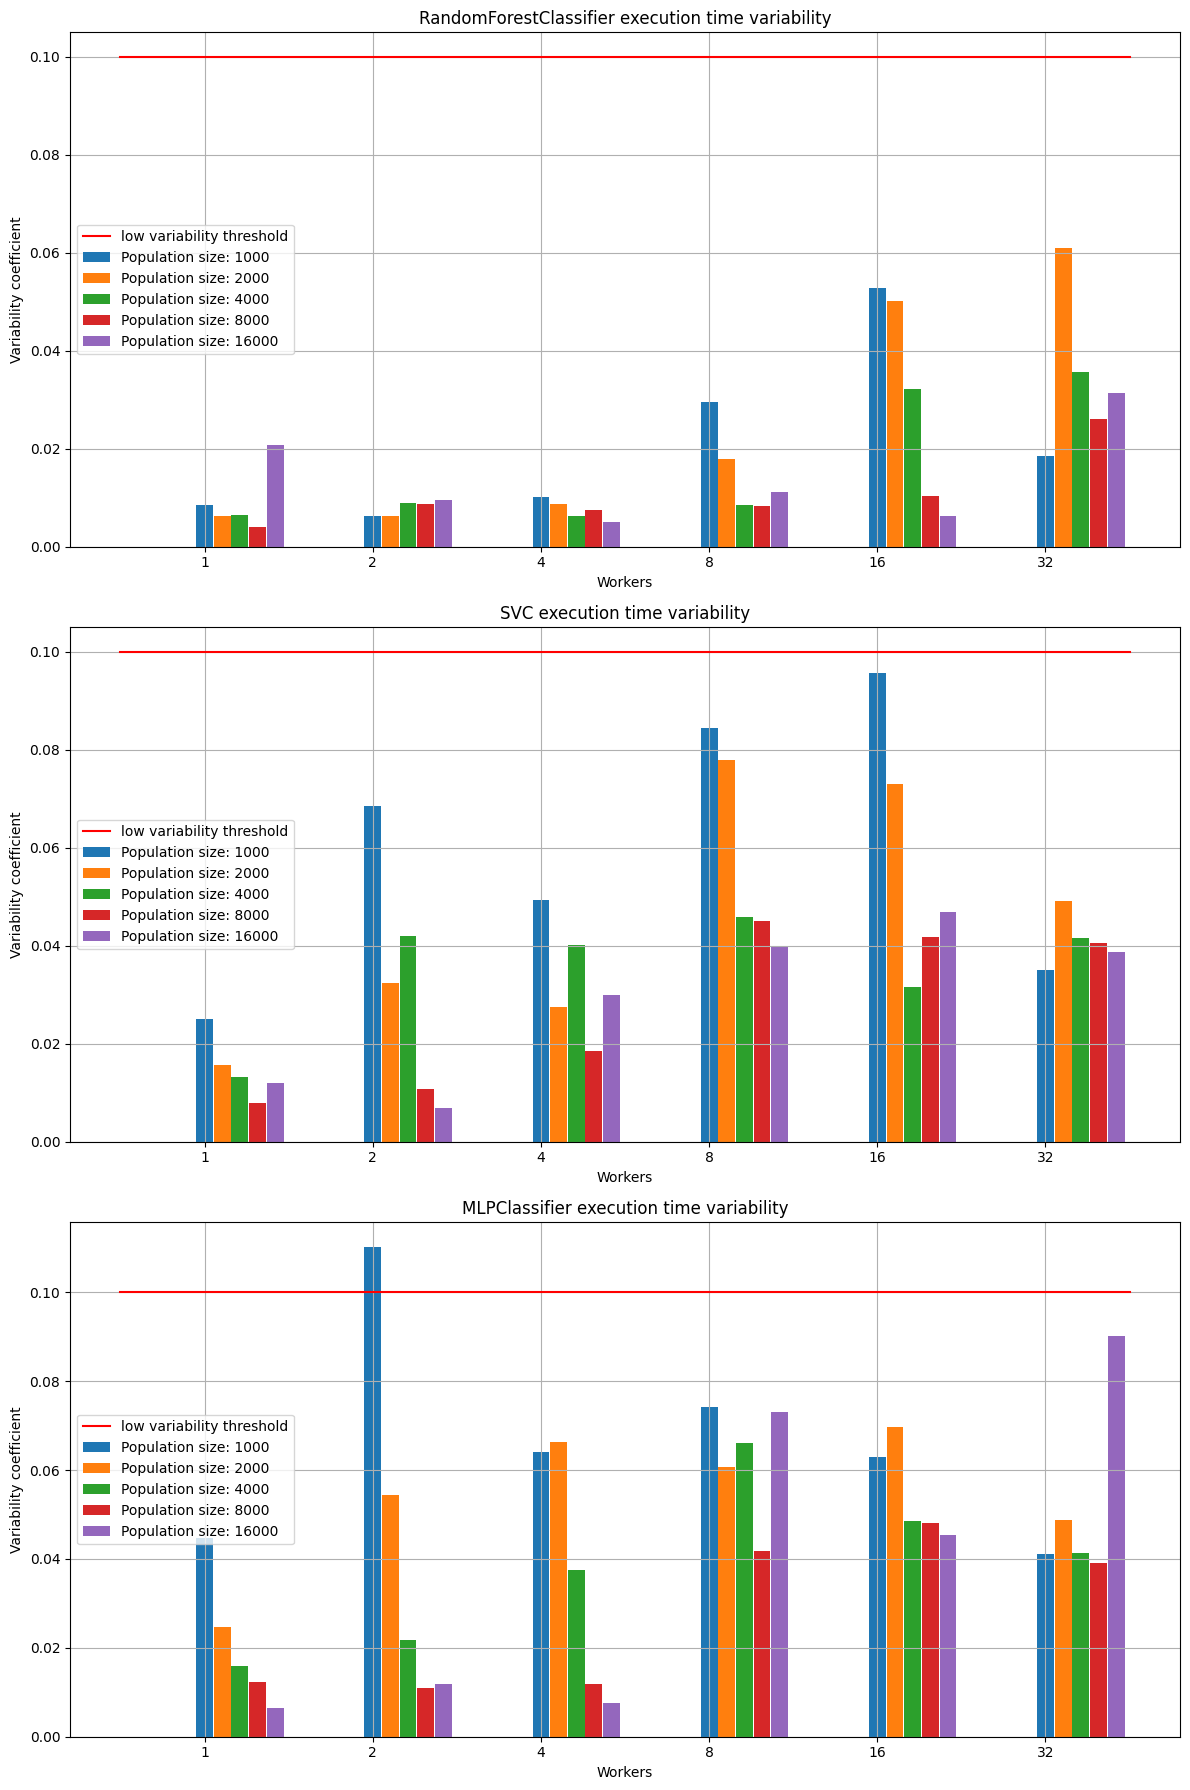

In [6]:
def plot_var_coeff(df: pd.DataFrame):
    models = df["classifier"].unique()
    workers = np.log2(np.array(df["workers"].unique()))
    population_sizes = df["population_size"].unique()
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))
    
    for model, ax in zip(models, axes):
        ax.plot([-0.5, 5.5], [0.1, 0.1], c="r", label="low variability threshold")
        for i, ps in enumerate(population_sizes):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            ax.set_title(f"{model} execution time variability")
            ax.set_xlabel("Workers")
            ax.set_ylabel("Variability coefficient")
            ax.bar(workers + i * 0.105, df[mask]["var_coeff"].values, width=0.1, label=f"Population size: {ps}")
    
            ax.set_xticks(workers, labels=[int(2**w) for w in workers])
            ax.grid()
            ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_var_coeff(ppga_df)

Dai test effettuati sembra che al variare del numero di worker e della
dimensione della popolazione il coefficiente di variabilità sia sempre sotto
il 10% eccetto per un caso.

# Analisi DEAP con multiprocessing

Il modulo DEAP offre due metodi per parallelizzare l'algoritmo genetico, il
primo tramite il modulo `multiprocessing` e il secondo tramite `scoop`. Di
seguito un'analisi della versione tramite `multiprocessing`. Le analisi sono
perfettamente analoghe alle precedenti.


In [7]:
deap_df = pd.read_csv("../datasets/deap_mp_16.csv")
deap_df

,classifier,population_size,workers,time,time_std
0,RandomForestClassifier,1000,1,20.714004,0.185683
1,RandomForestClassifier,1000,2,10.756239,0.066047
2,RandomForestClassifier,1000,4,5.603003,0.044590
3,RandomForestClassifier,1000,8,3.346872,0.103487
4,RandomForestClassifier,1000,16,2.059233,0.094090
...,...,...,...,...,...
85,MLPClassifier,16000,2,7.321839,0.042740
86,MLPClassifier,16000,4,4.708074,0.034155
87,MLPClassifier,16000,8,4.337388,0.102200
88,MLPClassifier,16000,16,4.113736,0.236253


## Tempo d'esecuzione

Come prima, alcuni plot rappresentati dell'andamento del tempo d'esecuzione in
funzione del diverso numero di worker e su diverse dimensioni dell'input.

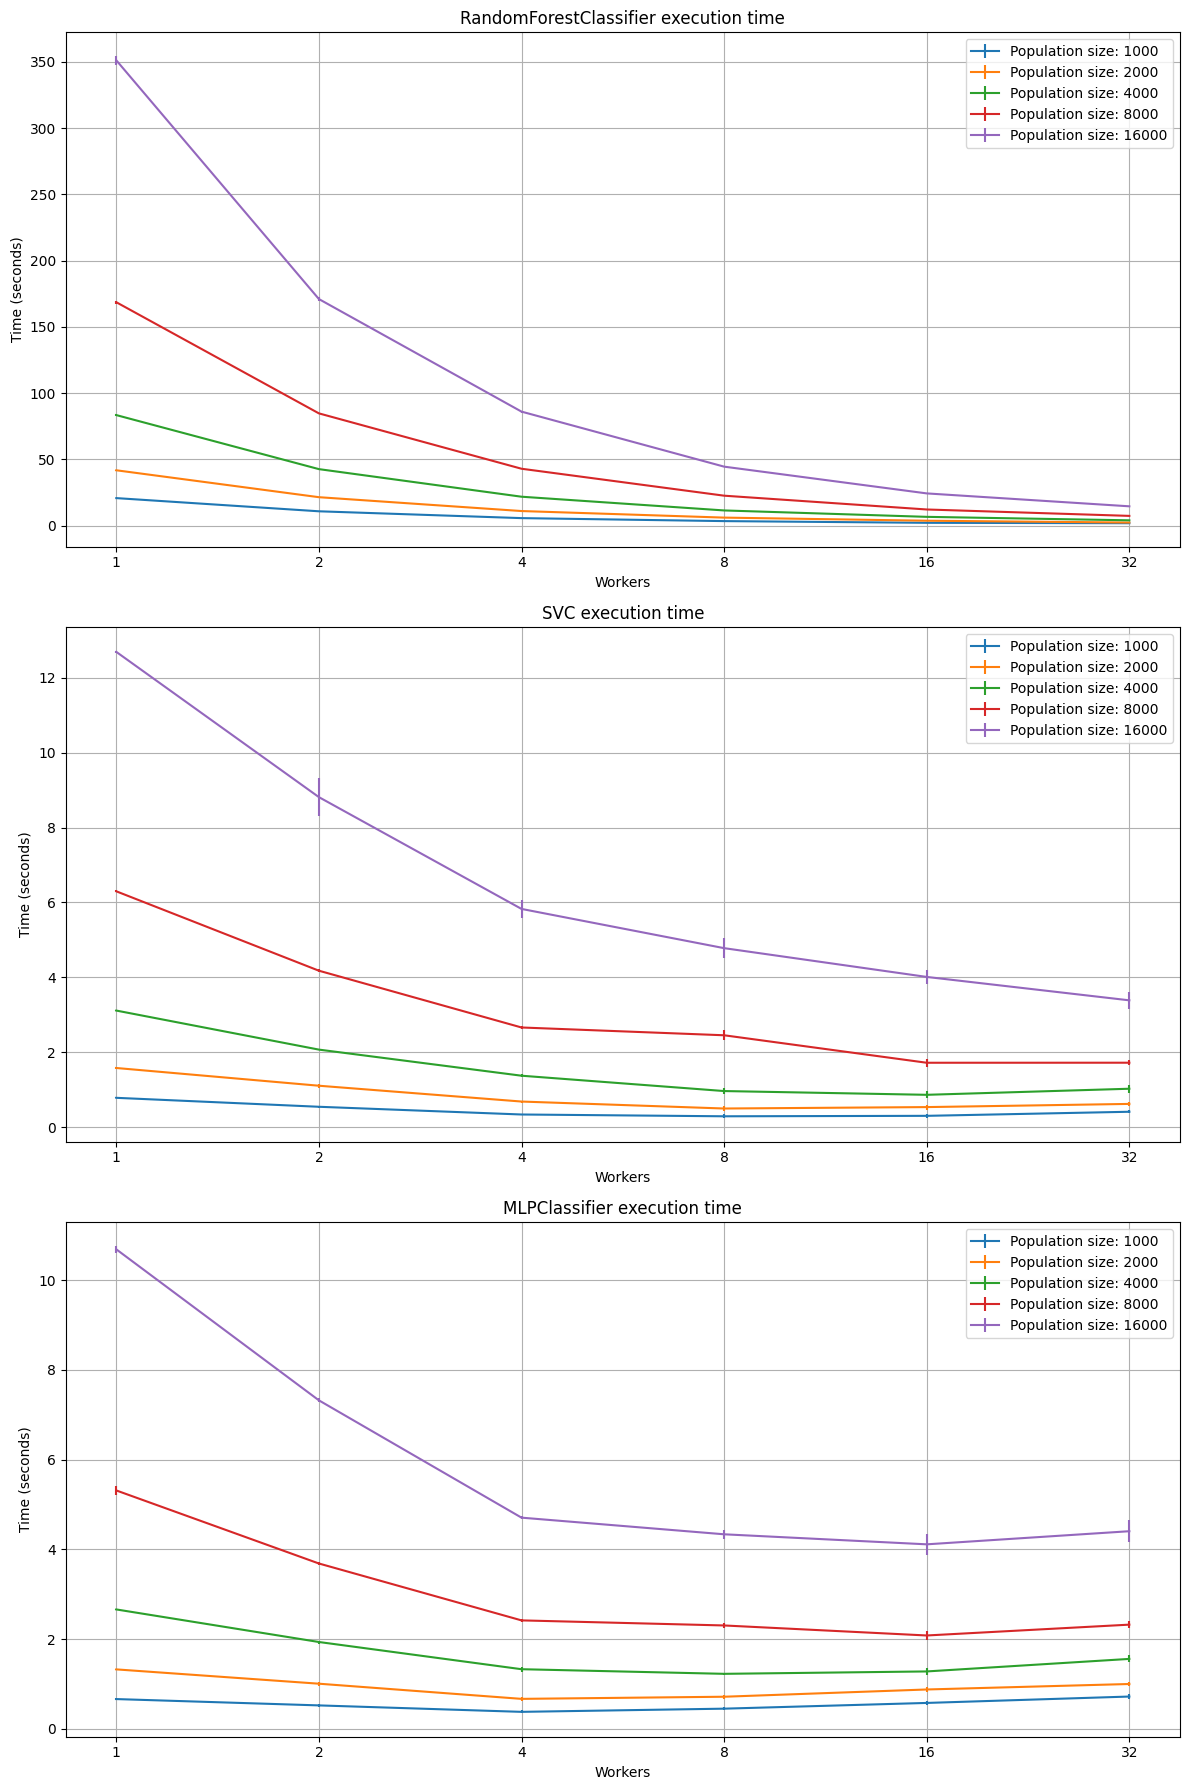

In [8]:
plot_time(deap_df)

## Speed up

Come prima andiamo ad analizzare lo speed up ottenuto.

In [9]:
reference_times = deap_df[deap_df['workers'] == 1].set_index(['classifier', 'population_size'])['time']

deap_df['speed_up'] = deap_df.apply(lambda row: reference_times.loc[(row['classifier'], row['population_size'])] / row['time'], axis=1)
deap_df

,classifier,population_size,workers,time,time_std,speed_up
0,RandomForestClassifier,1000,1,20.714004,0.185683,1.000000
1,RandomForestClassifier,1000,2,10.756239,0.066047,1.925766
2,RandomForestClassifier,1000,4,5.603003,0.044590,3.696947
3,RandomForestClassifier,1000,8,3.346872,0.103487,6.189063
4,RandomForestClassifier,1000,16,2.059233,0.094090,10.059087
...,...,...,...,...,...,...
85,MLPClassifier,16000,2,7.321839,0.042740,1.459570
86,MLPClassifier,16000,4,4.708074,0.034155,2.269875
87,MLPClassifier,16000,8,4.337388,0.102200,2.463866
88,MLPClassifier,16000,16,4.113736,0.236253,2.597819


Notiamo, sia dalla tabella che dal grafico di seguito, che lo speed up tramite
il modulo multiprocessing è generalmente migliore rispetto all'altro algoritmo.
Questo probabilmente dovuto a tecniche di bilanciamento del carico e di
comunicazione più avanzate. Il confronto vero e proprio sarà fatto di seguito.

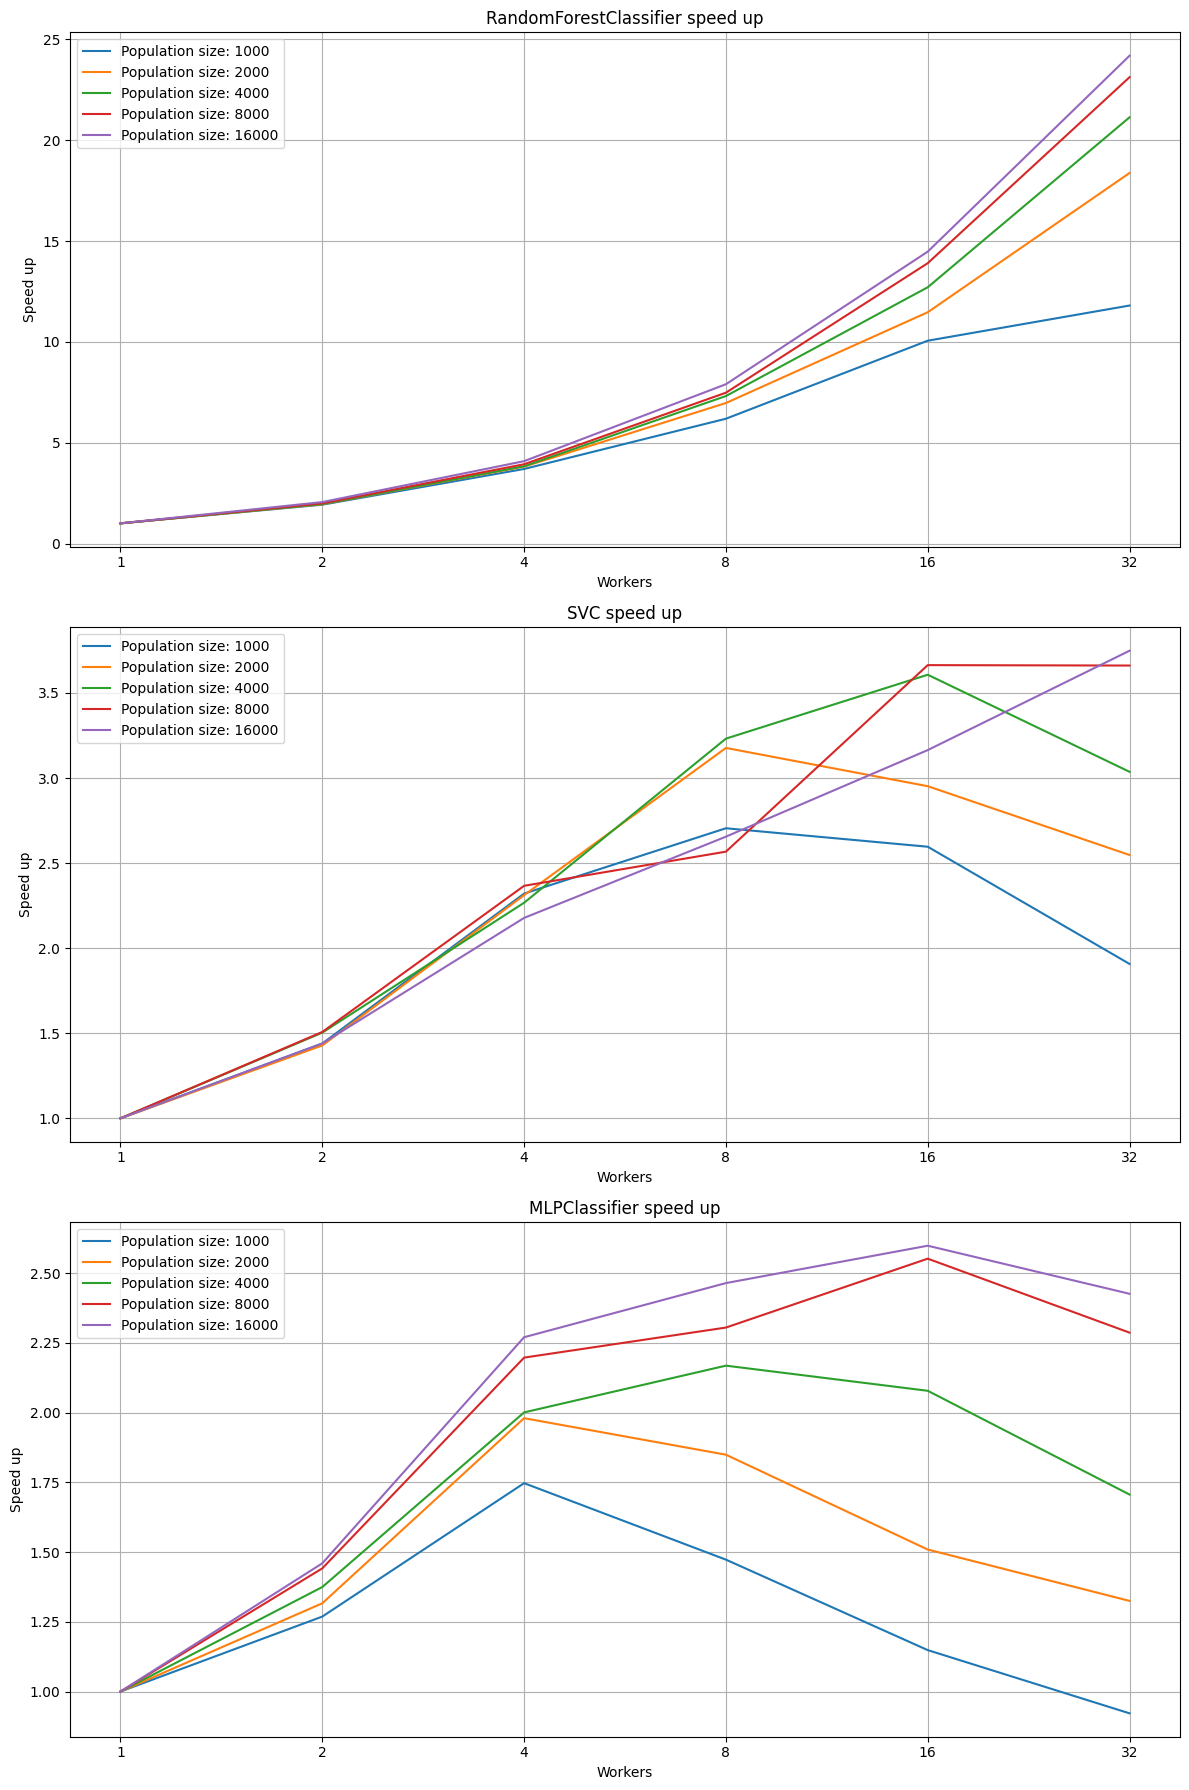

In [10]:
plot_speed_up(deap_df)

## Stabilità

Come in precedenza andiamo a calcolare il coefficiente di variabilità
dell'algoritmo.

In [11]:
deap_df["var_coeff"] = deap_df["time_std"] / deap_df["time"]
deap_df

,classifier,population_size,workers,time,time_std,speed_up,var_coeff
0,RandomForestClassifier,1000,1,20.714004,0.185683,1.000000,0.008964
1,RandomForestClassifier,1000,2,10.756239,0.066047,1.925766,0.006140
2,RandomForestClassifier,1000,4,5.603003,0.044590,3.696947,0.007958
3,RandomForestClassifier,1000,8,3.346872,0.103487,6.189063,0.030920
4,RandomForestClassifier,1000,16,2.059233,0.094090,10.059087,0.045692
...,...,...,...,...,...,...,...
85,MLPClassifier,16000,2,7.321839,0.042740,1.459570,0.005837
86,MLPClassifier,16000,4,4.708074,0.034155,2.269875,0.007255
87,MLPClassifier,16000,8,4.337388,0.102200,2.463866,0.023562
88,MLPClassifier,16000,16,4.113736,0.236253,2.597819,0.057430


A differenza del caso precedente è possibile, anche solo visivamente, notare
una maggiore variabilità nei tempi di esecuzione, soprattutto nel caso della
SVM e del MultiLayer Perceptron.


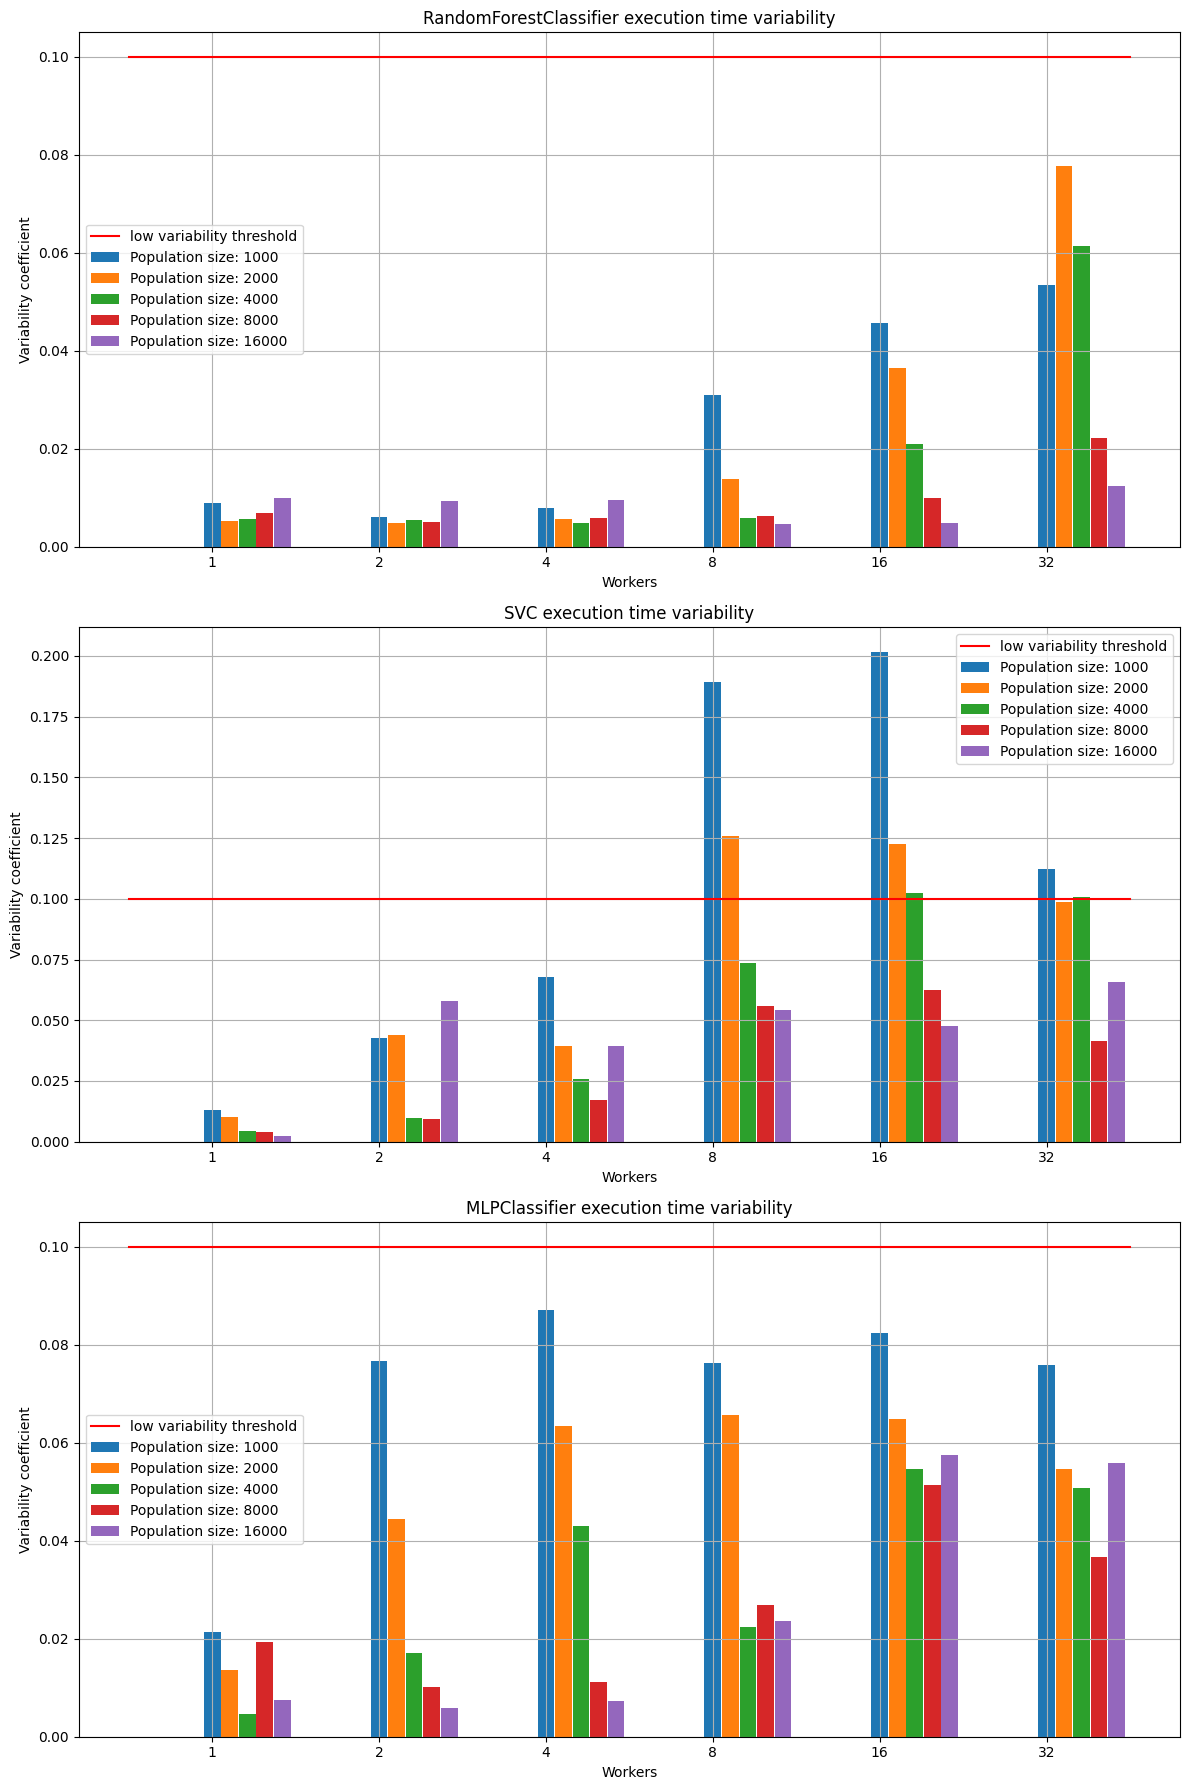

In [12]:
plot_var_coeff(deap_df)

# Confronto con DEAP

Passiamo a confrontare le prestazioni con la libreria DEAP. Procederemo
confrontando tre parametri:

- Tempo d'esecuzione
- Speed up
- Coefficiente di speed up

L'ultimo è un parametro che ci permette di paragonare lo speed up in modo
proporzionale tra i due algoritmi che possono aver ottenuto tempi d'esecuzione
differenti.

## Tempo d'esecuzione

Il primo confronto è semplicemente sul tempo d'esecuzione puro dei due
algoritmi:

In [13]:
time_cmp = pd.DataFrame({
    "classifier": ppga_df["classifier"].values,
    "population_size": ppga_df["population_size"].values,
    "workers": ppga_df["workers"].values,
    "ppga": ppga_df["time"].values,
    "deap": deap_df["time"].values,
})

time_cmp

,classifier,population_size,workers,ppga,deap
0,RandomForestClassifier,1000,1,16.235809,20.714004
1,RandomForestClassifier,1000,2,8.446167,10.756239
2,RandomForestClassifier,1000,4,4.404420,5.603003
3,RandomForestClassifier,1000,8,2.536529,3.346872
4,RandomForestClassifier,1000,16,1.869966,2.059233
...,...,...,...,...,...
85,MLPClassifier,16000,2,5.873115,7.321839
86,MLPClassifier,16000,4,3.631834,4.708074
87,MLPClassifier,16000,8,2.844125,4.337388
88,MLPClassifier,16000,16,2.562643,4.113736


Come possiamo vedere dai grafici di seguito sembra che DEAP sia leggermente
più lento.

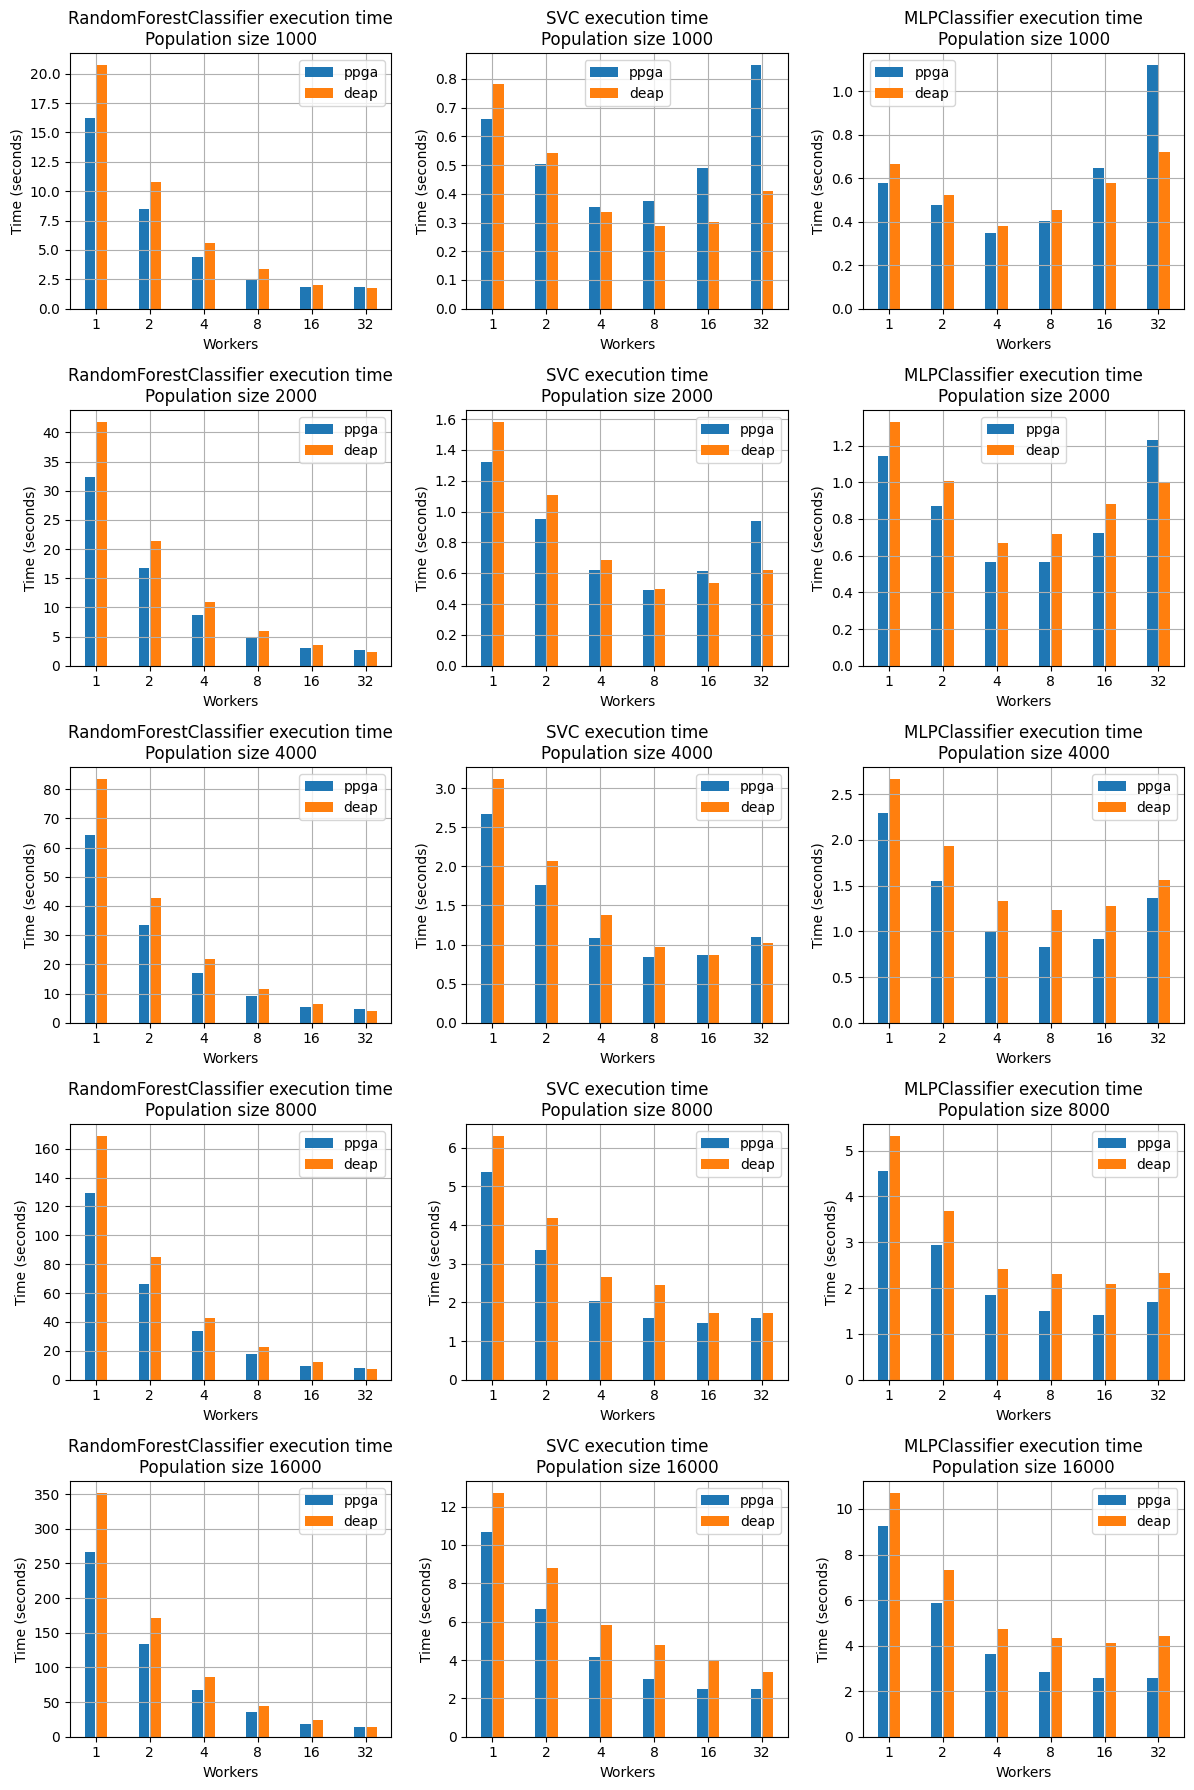

In [14]:
def plot_time_diff(df):
    models = df["classifier"].unique()
    workers = np.log2(df["workers"].unique())
    population_sizes = df["population_size"].unique()
    
    fig, axes = plt.subplots(len(population_sizes), len(models), figsize=(12, 18))
    
    for i, ps in enumerate(population_sizes):
        for j, model in enumerate(models):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][j].set_title(f"{model} execution time\nPopulation size {ps}")
            axes[i][j].set_xlabel("Workers")
            axes[i][j].set_ylabel("Time (seconds)")
            axes[i][j].bar(workers - 0.11, df[mask]["ppga"].values, width=0.2, label="ppga")
            axes[i][j].bar(workers + 0.11, df[mask]["deap"].values, width=0.2, label="deap")
    
            axes[i][j].set_xticks(workers, labels=[int(2**i) for i in workers])
            axes[i][j].legend()
            axes[i][j].grid()
    
    plt.tight_layout()
    plt.show()

plot_time_diff(time_cmp)

Di seguito un confronto tra il numero di volte in cui `ppga` ha offerto
performance migliori rispetto a DEAP.

In [15]:
ppga_better_time = time_cmp[time_cmp["ppga"] < time_cmp["deap"]]
print(f"ppga better than deap {len(ppga_better_time) / len(time_cmp) * 100.0:.2f}% of the times")

ppga better than deap 83.33% of the times


Andiamo a vedere i valori minimi, medi e massimi dell'aumento di performance.

In [16]:
improvement = (ppga_better_time["deap"] - ppga_better_time["ppga"]) / ppga_better_time["deap"] * 100.0
print(f"minimum improvement: {improvement.min():.2f}%")
print(f"mean improvement: {improvement.mean():.2f}%")
print(f"max improvement: {improvement.max():.2f}%")

minimum improvement: 1.46%
mean improvement: 20.27%
max improvement: 41.30%


Come vediamo `ppga` è tendenzialmente più veloce, mediamente del 20%.

Ripetiamo la stessa analisi ma considerando solo i casi in cui DEAP ha fornito
le performance migliori.

In [17]:
deap_better_time = time_cmp[time_cmp["deap"] < time_cmp["ppga"]]
print(f"deap better than ppga {len(deap_better_time) / len(time_cmp) * 100.0:.2f}% of the times")

improvement = (deap_better_time["ppga"] - deap_better_time["deap"]) / deap_better_time["ppga"] * 100.0
print(f"minimum improvement: {improvement.min():.2f}%")
print(f"mean improvement: {improvement.mean():.2f}%")
print(f"max improvement: {improvement.max():.2f}%")

deap better than ppga 16.67% of the times
minimum improvement: 0.71%
mean improvement: 18.74%
max improvement: 51.59%


Non sembrano esserci grandi differenze per quanto riguarda i valori minimi e
medi, ma è stato registrato almeno un caso in cui DEAP ha fornito performance
migliori del 50% rispetto a PPGA.

## Speed up

Passiamo ora al confronto dello speed up tra i due algoritmi. Le analisi saranno
analoghe a quelle fatte per il tempo d'esecuzione.

In [18]:
speedup_cmp = pd.DataFrame({
    "classifier": ppga_df["classifier"].values,
    "population_size": ppga_df["population_size"].values,
    "workers": ppga_df["workers"].values,
    "ppga": ppga_df["speed_up"].values,
    "deap": deap_df["speed_up"].values,
})

speedup_cmp = speedup_cmp[speedup_cmp["workers"] != 1]
speedup_cmp

,classifier,population_size,workers,ppga,deap
1,RandomForestClassifier,1000,2,1.922270,1.925766
2,RandomForestClassifier,1000,4,3.686253,3.696947
3,RandomForestClassifier,1000,8,6.400798,6.189063
4,RandomForestClassifier,1000,16,8.682410,10.059087
5,RandomForestClassifier,1000,32,8.959281,11.803704
...,...,...,...,...,...
85,MLPClassifier,16000,2,1.571575,1.459570
86,MLPClassifier,16000,4,2.541427,2.269875
87,MLPClassifier,16000,8,3.245302,2.463866
88,MLPClassifier,16000,16,3.601767,2.597819


Stavolta sembra che DEAP abbia valori di speed up migliori, come si può notare
dai grafici riportati di seguito.

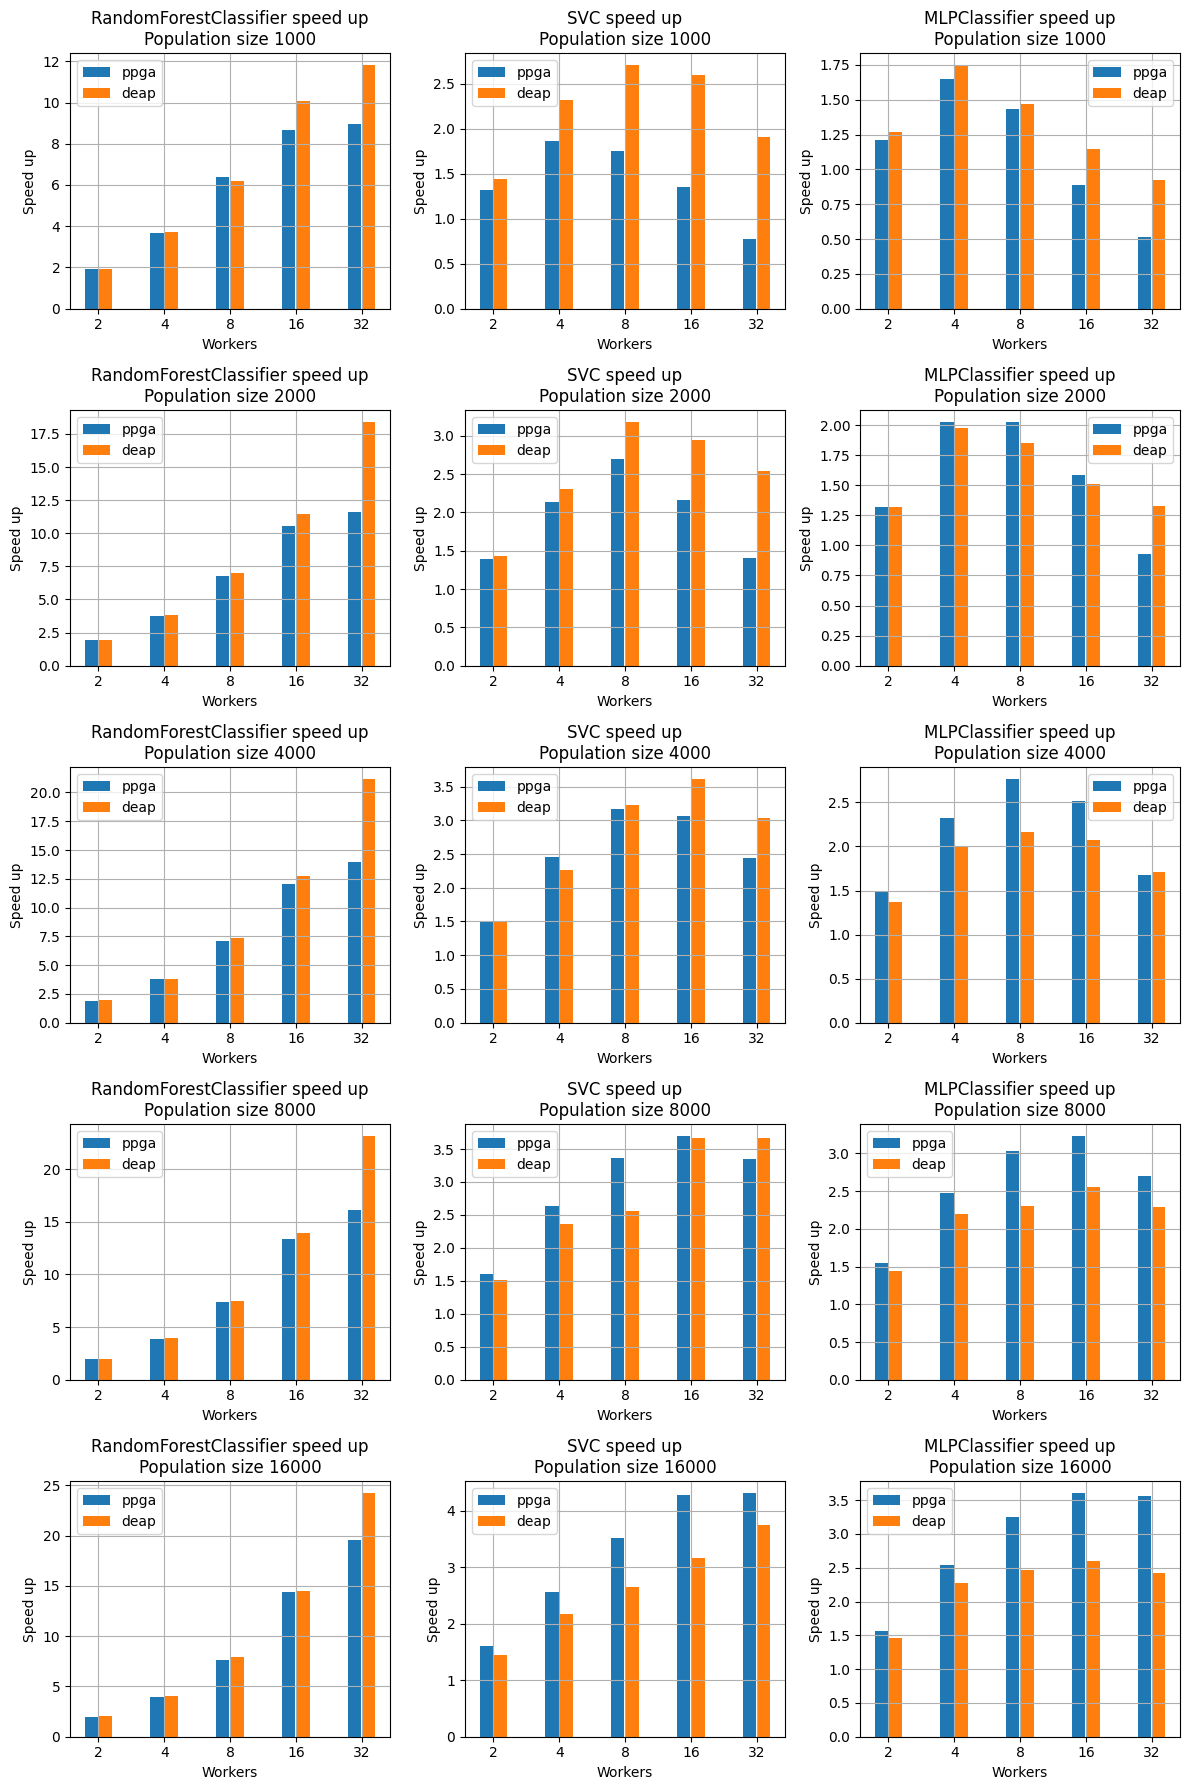

In [19]:
def plot_time_diff(df):
    models = df["classifier"].unique()
    workers = np.log2(df["workers"].unique())
    population_sizes = df["population_size"].unique()
    
    fig, axes = plt.subplots(len(population_sizes), len(models), figsize=(12, 18))
    
    for i, ps in enumerate(population_sizes):
        for j, model in enumerate(models):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][j].set_title(f"{model} speed up\nPopulation size {ps}")
            axes[i][j].set_xlabel("Workers")
            axes[i][j].set_ylabel("Speed up")
            axes[i][j].bar(workers - 0.11, df[mask]["ppga"].values, width=0.2, label="ppga")
            axes[i][j].bar(workers + 0.11, df[mask]["deap"].values, width=0.2, label="deap")
    
            axes[i][j].set_xticks(workers, labels=[int(2**i) for i in workers])
            axes[i][j].legend()
            axes[i][j].grid()
    
    plt.tight_layout()
    plt.show()

plot_time_diff(speedup_cmp)

Andiamo però a vedere quante volte DEAP è stato migliore di PPGA come abbiamo
fatto in precedenza.

In [20]:
ppga_better = speedup_cmp[speedup_cmp["ppga"] > speedup_cmp["deap"]]
print(f"ppga better than deap {len(ppga_better) / len(speedup_cmp) * 100.0:.2f}% of the times")

deap_better = speedup_cmp[speedup_cmp["deap"] > speedup_cmp["ppga"]]
print(f"deap better than ppga {len(deap_better) / len(speedup_cmp) * 100.0:.2f}% of the times")

ppga better than deap 40.00% of the times
deap better than ppga 60.00% of the times


In questo caso DEAP risulta avere i migliori valori di speed la maggior parte
delle volte.

## Coefficiente di speed up

Confrontare il tempo d'esecuzione può essere un buon indice per paragonare le
performance di un algoritmo, quando però andiamo a paragonare i valori di speed
up non otteniamo una vera e propria misura di quanto un modello di calcolo
parallelo sia migliore rispetto ad un altro. Questo è anche dovuto al fatto
che il tempo d'esecuzione, a parità di worker impiegati, potrebbe variare.
Diventa quindi necessario ricavare una misura che sia proporzionale al tempo
d'esecuzione. Di seguito viene calcolato un "coefficiente di speed up"

$$\frac{s}{t}$$

dove $s$ è lo speed up ottenuto e $t$ il tempo totale d'esecuzione.

In [21]:
speedup_coeff_cmp = pd.DataFrame({
    "classifier": ppga_df["classifier"].values,
    "population_size": ppga_df["population_size"].values,
    "workers": ppga_df["workers"].values,
    "ppga": (ppga_df["speed_up"] / ppga_df["time"]).values,
    "deap": (deap_df["speed_up"] / deap_df["time"]).values,
})

speedup_coeff_cmp = speedup_coeff_cmp[speedup_coeff_cmp["workers"] != 1]
speedup_coeff_cmp

,classifier,population_size,workers,ppga,deap
1,RandomForestClassifier,1000,2,0.227591,0.179037
2,RandomForestClassifier,1000,4,0.836944,0.659815
3,RandomForestClassifier,1000,8,2.523448,1.849208
4,RandomForestClassifier,1000,16,4.643085,4.884871
5,RandomForestClassifier,1000,32,4.943931,6.726243
...,...,...,...,...,...
85,MLPClassifier,16000,2,0.267588,0.199345
86,MLPClassifier,16000,4,0.699764,0.482124
87,MLPClassifier,16000,8,1.141055,0.568053
88,MLPClassifier,16000,16,1.405490,0.631499


Dalla tabella e dai grafici riportati di seguito possiamo notare come PPGA
offra, nella maggior parte dei casi, un coefficiente migliore.

Dobbiamo però considerare anche l'andamento di tale coefficiente caso per caso.
Se rimane stabile o tende a crescere con il crescere del numero di worker,
potrebbe essere un buon indice per valutare la scalabilità dell'algoritmo
su un numero ancora più alto di worker.


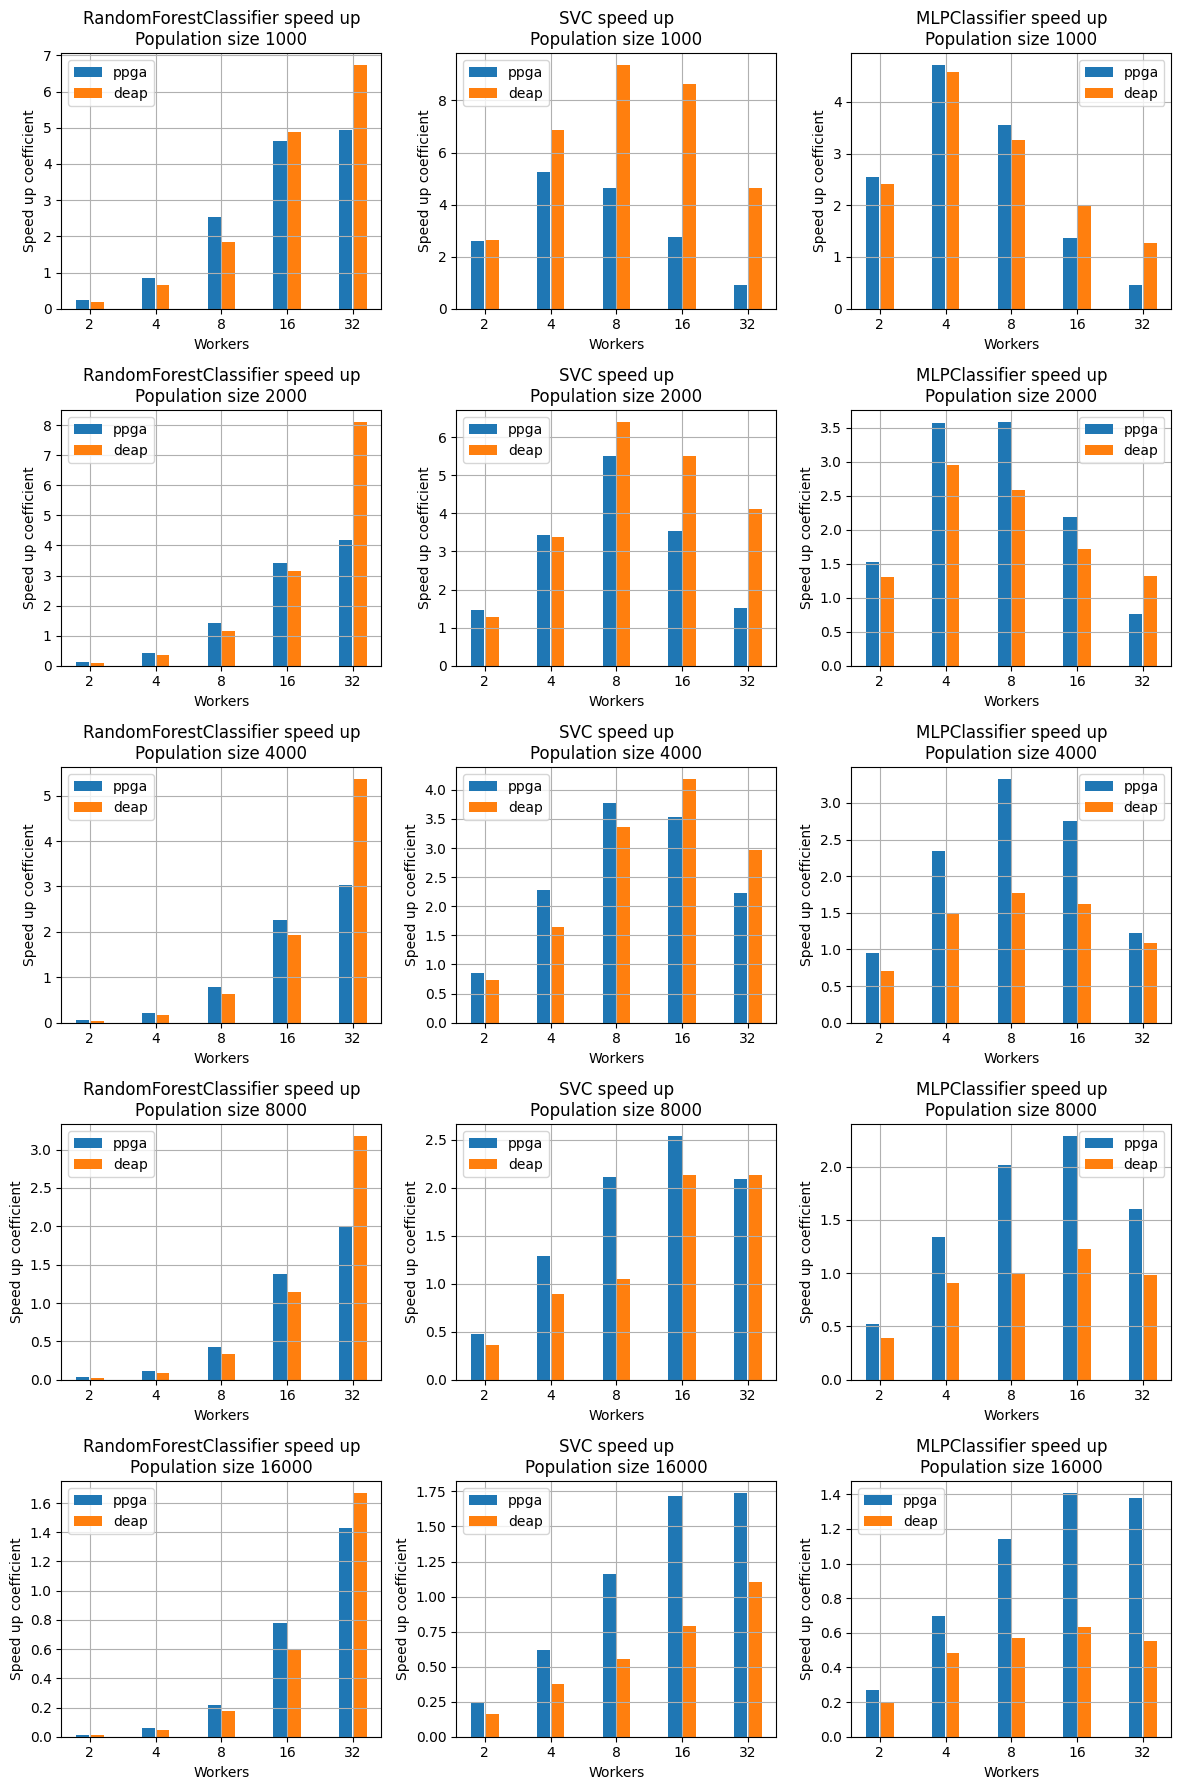

In [25]:
def plot_time_diff(df):
    models = df["classifier"].unique()
    workers = np.log2(df["workers"].unique())
    population_sizes = df["population_size"].unique()
    
    fig, axes = plt.subplots(len(population_sizes), len(models), figsize=(12, 18))
    
    for i, ps in enumerate(population_sizes):
        for j, model in enumerate(models):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][j].set_title(f"{model} speed up\nPopulation size {ps}")
            axes[i][j].set_xlabel("Workers")
            axes[i][j].set_ylabel("Speed up coefficient")
            axes[i][j].bar(workers - 0.11, df[mask]["ppga"].values, width=0.2, label="ppga")
            axes[i][j].bar(workers + 0.11, df[mask]["deap"].values, width=0.2, label="deap")
    
            axes[i][j].set_xticks(workers, labels=[int(2**i) for i in workers])
            axes[i][j].legend()
            axes[i][j].grid()
    
    plt.tight_layout()
    plt.show()

plot_time_diff(speedup_coeff_cmp)

Come già detto, il coefficiente vuole essere un indice di quanto l'algoritmo
scala bene con il crescere del numero di worker. Come possiamo vedere, una
casistica in cui il carico dei singoli worker tende ad essere leggero, un
approccio in cui c'è un bilanciamento automatico e dinamico del carico di lavoro
risulta essere vincente sia in termini di tempo d'esecuzione, sia in termini di
utilizzo delle risorse fornite (in questo caso i core multipli della macchina).

Quando però il workload si fa più intenso, sembra essere più vantaggioso
partizionare subito l'input e lasciare lavorare i worker senza ulteriori
overhead di sincronizzazione e comunicazione.

In [23]:
ppga_better = speedup_coeff_cmp[speedup_coeff_cmp["ppga"] > speedup_coeff_cmp["deap"]]
print(f"ppga better than deap {len(ppga_better) / len(speedup_coeff_cmp) * 100.0:.2f}% of the times")

deap_better = speedup_coeff_cmp[speedup_coeff_cmp["deap"] > speedup_coeff_cmp["ppga"]]
print(f"deap better than ppga {len(deap_better) / len(speedup_cmp) * 100.0:.2f}% of the times")

ppga better than deap 73.33% of the times
deap better than ppga 26.67% of the times


# Conclusioni

In quanto a tempo d'esecuzione sembra prevalere PPGA nella maggior parte dei
casi ma nella pratica il miglioramento non è molto rilevante.

Sui valori di speed up delle versioni parallele è chiaro come DEAP riesca in
molti casi a sfruttare meglio le risorse computazionali a disposizione. La
differenza tende però ad appianarsi quando il carico di lavoro di ogni worker
si fa sempre più grande.

Per l'ultimo coefficiente valgono più o meno le stesse considerazioni fatte
sullo speed up. Come si nota dai grafici, i casi in cui il coefficiente è più
alto per PPGA sono quelli con pochi worker, che dunque saranno più carichi
di lavoro. Qui diventa determinate il tempo d'esecuzione, tendenzialmente 
inferiore, di PPGA.

Se però entrano in gioco un alto numero di worker e workload eterogenei, la
miglior scelta ricade sul `multiprocessing.Pool` utilizzato da DEAP.